## Optimisation - or how to fit data

In this notebook, we will review briefly various concepts and Python tools that can be used to perform optimisation, model solving, and curve fitting.

***Dependencies***
- numpy
- scipy
- matplotlib
- uncertainties

Note: this notebook was originally written in collaboration with Oscar Branson (Cambridge) and Andrew Valentine (ANU-RSES) in the framework of the 'data surgeries' event from the Data Science research theme at RSES.

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as tri

import numpy as np
import scipy

# We fix the random seed to always get the same problem

np.random.seed(seed=42)

# Generating fake data: A simple curve fit with noise

We will fit a second order polynomial function, that can be calculate with the forward model function defined below:

In [2]:
def forward_model(x,a,b,c):
    """forward model for our problem"""
    return a + x*b + c*x*x

Nous pouvons utiliser cette fonction pour générer de fausses données

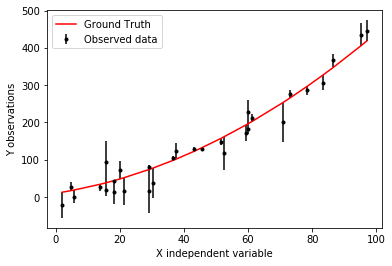

In [3]:
# true parameters
a = 10.0
b = 1.321
c = 0.02978

N = 30

x = np.sort(100*np.random.rand(N))
y = forward_model(x,a,b,c)

# Real world observations are noisy...
# we have random errors there, no systematic bias
ese = 30*np.random.randn(N)

y_observed = y + ese

plt.errorbar(x,y_observed,yerr=ese,fmt='.',color="k",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.xlabel("X independent variable")
plt.ylabel("Y observations")
plt.legend()

# Fitting the data

We can guess look at the figure that the data follow some second order polynomial, or maybe a third. Simplicity is great, so we chose a second order polynomial.

The idea is now to define a model *m* which fits our data *d* with some parameters we can tune. We basically want to map:

$d = G(m)$ , eq. 1

In this case, our model is a second order polynomial function:

$d = a + b*x + c*x*x$ . eq. 2

An easy and well used way to fit our data with eq. 2 is to use **least-square regression**.

The least-square problem consists in minimizing the misfit between the observation $d$ and the model $m$:

$misfit = \sum_{i=1}^{n}{(d_n-m_n)^2}$ , eq. 3

We want to minimize this value. The eq. 3 is called the **objective function** of our problem. Eq. 3 is a least-square objective function. Other functions can be used, like the least absolute value objective function (a.k.a. L1 norm).

There is several way to do that. In python, one of the simplest is to **use the curve_fit function of scipy**. In order to use this function, we need to have another one that allows calculating eq. 1. Let's do that.

In [4]:
# we need to import curve_fit for fitting our curve
# we also import uncertainties for error propagation
from scipy.optimize import curve_fit 

# then we fit and record the best parameters popt 
# and the covariance matrix pcov
popt, pcov = curve_fit(forward_model,x,y_observed) 

# parameter errors are estimated from the square root of the diagonal of the covariance matrix
perr = np.sqrt(np.diag(pcov)) 

print("Obtained parameters:")
print(popt)

# for practical reasons, we can also declare an objective function function :
def least_squares(y_observed,y_calculated):
    """least square criterion"""
    return np.sum((y_observed-y_calculated)**2)

Obtained parameters:
[8.22630634 0.76492451 0.03746273]


Fit RMSE is: 20492.067673913156


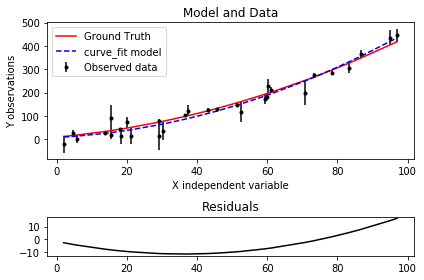

In [5]:
# we calculate the best estimate
y_pred_curvefit = forward_model(x,*popt) # parameter unwrapping (*popt) works only in Python 3

print("Fit RMSE is: "+str(least_squares(y_observed,y_pred_curvefit)))

plt.figure()

plt.subplot(3,1,(1,2))
plt.errorbar(x,y_observed,yerr=ese,fmt='.',color="k",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.plot(x,y_pred_curvefit,"b--",label="curve_fit model")
plt.title("Model and Data")
plt.xlabel("X independent variable")
plt.ylabel("Y observations")
plt.legend()

plt.subplot(3,1,3)
plt.plot(x,(y_pred_curvefit - y),"k-")
plt.title("Residuals")

plt.tight_layout()

# Hum, weird fit shape... 

Wait, **we did not take into account the errors...** 

Indeed, we should ponderate the square differences between *d* and *m* with the errors $\sigma$ on *d*.

Eq. 3 becomes in this case:

$misfit = \sum_{i=1}^{n}{\frac{(d_n-m_n)^2}{\sigma_n ^2}}$ , eq. 4

Fortunately, curve_fit can accept this in the function call.

Obtained parameters:
[10.21233558  1.26839197  0.03079699]
Fit RMSE is: 28.783529389050518


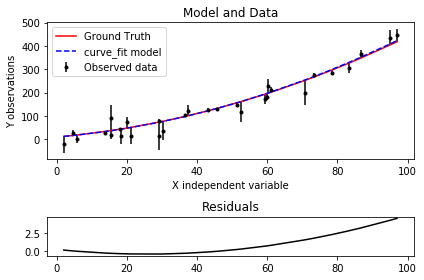

In [6]:
# we declare a new least-squares function with errors taken into account
def least_squares_ponderated(y_observed,y_calculated, y_sigmas):
    """least square criterion"""
    return np.sum((y_observed-y_calculated)**2/(y_sigmas**2))

# then we fit and record the best parameters popt 
# and the covariance matrix pcov
popt, pcov = curve_fit(forward_model,x,y_observed,sigma=ese) 

print("Obtained parameters:")
print(popt)

# parameter errors are estimated from the square root of the diagonal of the covariance matrix
perr = np.sqrt(np.diag(pcov)) 

# we calculate the best estimate
y_pred_curvefit = forward_model(x,*popt) # parameter unwrapping (*popt) works only in Python 3
print("Fit RMSE is: "+str(least_squares_ponderated(y_observed,y_pred_curvefit,ese)))

plt.figure()

plt.subplot(3,1,(1,2))
plt.errorbar(x,y_observed,yerr=ese,fmt='.',color="k",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.plot(x,y_pred_curvefit,"b--",label="curve_fit model")
plt.title("Model and Data")
plt.xlabel("X independent variable")
plt.ylabel("Y observations")
plt.legend()

plt.subplot(3,1,3)
plt.plot(x,(y_pred_curvefit - y),"k-")
plt.title("Residuals")

plt.tight_layout()

# Experiment :

    - change the scale of the errors. What happens for the straight and ponderated least-squares fits ?
    
So, are errors important ?